# 0.0 Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import inflection

import pandas               as pd
import seaborn              as sns
import numpy                as np
import plotly.express       as px
import plotly.graph_objects as Go

from plotly.subplots       import make_subplots
from IPython.core.display  import HTML
from matplotlib            import pyplot as plt
from scipy.sparse          import csc_matrix
from sklearn.neighbors     import NearestNeighbors

## 0.1 Helper Functions

In [2]:
#pd.set_option('display.max_rows', 100)
#pd.set_option('display.max_columns', 100)

#plt.rcParams['figure.figsize'] = (15,6)


def jupyter_settings():
        %matplotlib inline
        
        plt.style.use('bmh')
        plt.rcParams['figure.figsize'] = [25 , 12]
        plt.rcParams['font.size'] = 24
        
        display( HTML( '<style>.container { width:100% !important; }</style>') )
        pd.options.display.max_columns = None
        pd.options.display.max_rows = None
        pd.set_option( 'display.expand_frame_repr', False )
        
        sns.set()

## 0.2 Loading Data

In [3]:
df_books = pd.read_csv('data/Books.csv')
df_ratings = pd.read_csv('data/Ratings.csv')
df_users = pd.read_csv('data/Users.csv')

# 1.0 Descrição dos Dados

## 1.1 Merge datasets

In [4]:
df1 = df_books.merge(df_ratings, how='inner', on='ISBN')

In [5]:
df1 = df1.merge(df_users, how='inner', on='User-ID')

## 1.2 Rename Columns

In [6]:
df1.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'User-ID', 'Book-Rating',
       'Location', 'Age'],
      dtype='object')

In [7]:
colds_old = ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
             'Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'User-ID', 'Book-Rating',
             'Location', 'Age']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, colds_old))

#rename
df1.columns = cols_new

## 1.3 Data Dimensions

In [8]:
print( 'Number of Rows: {}'.format(df1.shape[0]))
print( 'Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1031136
Number of Cols: 12


## 1.4 Data Types

In [9]:
df1.dtypes

isbn                    object
book_title              object
book_author             object
year_of_publication     object
publisher               object
image_url_s             object
image_url_m             object
image_url_l             object
user_id                  int64
book_rating              int64
location                object
age                    float64
dtype: object

## 1.5 Check NA

In [10]:
df1.isna().sum()

isbn                        0
book_title                  0
book_author                 1
year_of_publication         0
publisher                   2
image_url_s                 0
image_url_m                 0
image_url_l                 4
user_id                     0
book_rating                 0
location                    0
age                    277835
dtype: int64

## 1.6 Change Dtypes

In [11]:
df1['year_of_publication'] = df1['year_of_publication'].apply(lambda x: 0 if x == 'Gallimard' else 0 
                                                                       if x == 'DK Publishing Inc'  else x)

In [12]:
df1['year_of_publication'] = df1['year_of_publication'].astype('int64')

## 1.7 Descriptive Statistics

In [13]:
num_attributes = df1.select_dtypes(include=['int64', 'int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'int32', 'datetime64[ns]'])

In [14]:
#Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
                  
#concat
m1 = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m1.columns = ['attributes,', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m1 

,"attributes,",min,max,range,mean,median,std,skew,kurtosis
0,year_of_publication,0.0,2050.0,2050.0,1968.187280,1997.0,231.133434,-8.389403,68.455203
1,user_id,2.0,278854.0,278852.0,140594.503506,141210.0,80524.619993,-0.023980,-1.226564
2,book_rating,0.0,10.0,10.0,2.839051,0.0,3.854155,0.752419,-1.215034
3,age,0.0,244.0,244.0,37.397648,NaN,14.098245,2.788844,27.435143


# 2.0 Feature Engineering

In [15]:
df2 = df1.copy()

## 2.1 Country Extract

In [16]:
df2['country'] = df2['location'].str.extract('([^, ]+$)', expand=True)

## 2.2 Age Group

In [17]:
df2['age_group'] = df2['age'].apply(lambda x: 'young' if (x >= 18 ) & (x < 35) else 'adult' 
                                                                       if (x >= 35 ) & (x < 65) else 'senior' if (x >= 65) else 'NaN')

# 3.0 Data Filtering

## 3.1 Book Rating Filter

In [18]:
df3 = df2[df2['book_rating'] > 0]

In [19]:
df3.shape

(383842, 14)

## 3.1 Age Filter

In [20]:
df3.describe()

,year_of_publication,user_id,book_rating,age
count,383842.000000,383842.000000,383842.000000,269621.000000
mean,1965.631557,136031.461260,7.626701,36.835829
std,243.241671,80482.299401,1.841339,13.753045
min,0.000000,8.000000,1.000000,0.000000
25%,1992.000000,67591.000000,7.000000,28.000000
50%,1997.000000,133789.000000,8.000000,35.000000
75%,2001.000000,206219.000000,9.000000,45.000000
max,2050.000000,278854.000000,10.000000,244.000000


# 4.0 EDA

In [21]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Book Rating 

<AxesSubplot: xlabel='book_rating'>

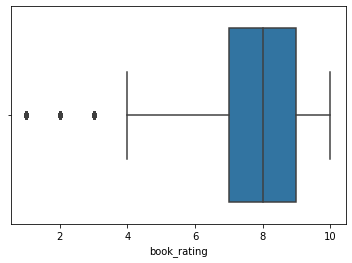

In [22]:
sns.boxplot(data=df4, x='book_rating')

### 4.1.2 Age

<AxesSubplot: xlabel='age'>

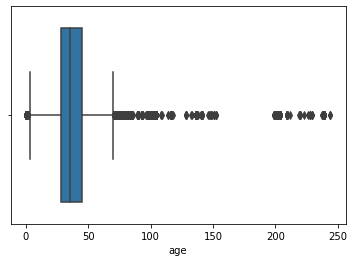

In [23]:
sns.boxplot(data=df4, x='age')

### 4.1.3 Year Publication

<AxesSubplot: xlabel='year_of_publication'>

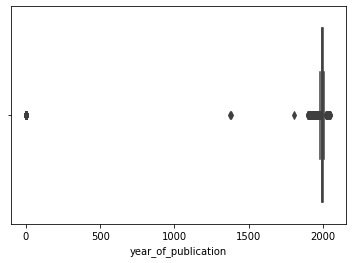

In [24]:
sns.boxplot(data=df4, x='year_of_publication')

## 4.2 Bivariate Analysis

<Figure size 1800x864 with 0 Axes>

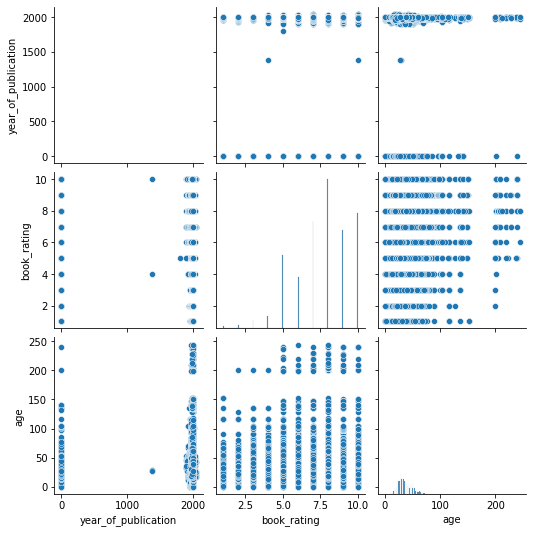

In [25]:
cols = ['user_id']
df42 = df4.drop( cols, axis=1 )

plt.figure( figsize=(25, 12) )
sns.pairplot( df42 )

## 4.2.1 Quantity x Mean

In [26]:
aux = df4.loc[:, ['book_title', 'book_rating']].groupby( 'book_title' ).mean().reset_index()
aux.columns = ['book_title', 'mean_rating']

aux2 = df4.loc[:, ['book_title', 'book_rating']].groupby('book_title').count().reset_index()
aux2.columns = ['book_title', 'count_rating']

aux = pd.merge( aux, aux2, how='inner', on='book_title' )

aux.head()

,book_title,mean_rating,count_rating
0,A Light in the Storm: The Civil War Diary of ...,9.000000,1
1,"Ask Lily (Young Women of Faith: Lily Series, ...",8.000000,1
2,Dark Justice,10.000000,1
3,Earth Prayers From around the World: 365 Pray...,7.142857,7
4,Final Fantasy Anthology: Official Strategy Gu...,10.000000,2


<AxesSubplot: xlabel='count_rating', ylabel='mean_rating'>

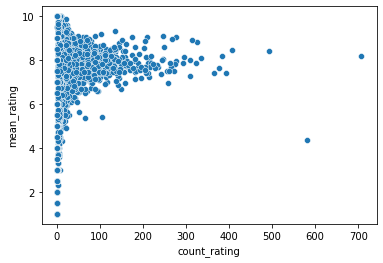

In [27]:
sns.scatterplot(data=aux, x='count_rating', y='mean_rating')

## 4.2.2 Quantity x Age

In [28]:
aux3 = df4.loc[:, ['book_title', 'age']].groupby( 'book_title' ).mean().reset_index()
aux3 = aux3.rename(columns={'age': 'mean_age'})
aux = pd.merge( aux, aux3, how='inner', on='book_title' )

<AxesSubplot: xlabel='count_rating', ylabel='mean_age'>

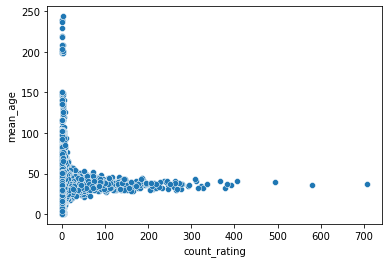

In [29]:
sns.scatterplot(data=aux, x='count_rating', y='mean_age')

## 4.2.3 Quantity Book Rating x Age

In [30]:
aux4 = df4[['age', 'book_rating']].groupby('age').count().reset_index()

<AxesSubplot: xlabel='age', ylabel='book_rating'>

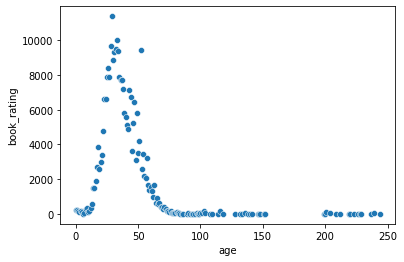

In [31]:
sns.scatterplot(data=aux4, x='age', y='book_rating')

In [32]:
aux = df4[['book_rating', 'book_title']].groupby('book_title').count().reset_index()

In [33]:
aux['quantity_rating'] = aux['book_rating'].apply(lambda x: '1-5' if (x >= 1) & (x <= 5) else
                                                            '6-10' if (x > 5) & (x <= 10) else
                                                            '11-100' if (x > 10) & (x <= 100) else '> 100')

In [34]:
aux['quantity_rating'].value_counts(normalize=True)

1-5       0.920010
6-10      0.042783
11-100    0.035790
> 100     0.001416
Name: quantity_rating, dtype: float64

array([[<AxesSubplot: title={'center': 'book_rating'}>]], dtype=object)

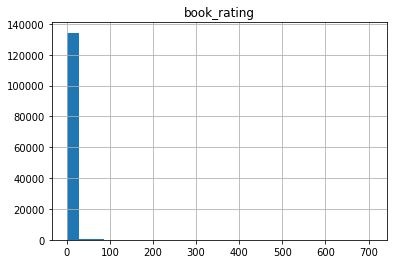

In [35]:
aux.hist(bins=25)

## 4.2.4 Quantity Book Rating x Country

In [36]:
aux = df4['country'].value_counts(normalize=True).head(10).reset_index()

<AxesSubplot: xlabel='index', ylabel='country'>

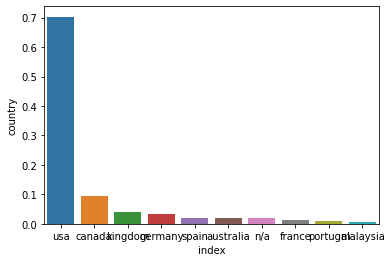

In [37]:
sns.barplot(data=aux, x='index', y='country')

## 4.3 Multivariate Analysis

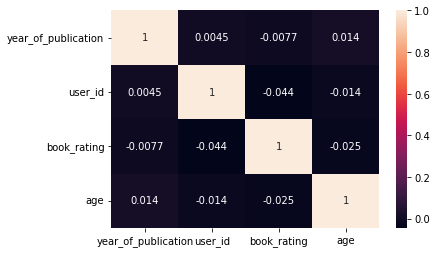

In [38]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

# 5.0 Data Preparation

In [39]:
df5 = df4.copy()

## 5.1 Data Filter for modeling

In [40]:
df5 = df5[(df5['age'] >= 18) & (df5['age'] <= 85)]

In [41]:
df5 = df5[(df5['year_of_publication'] >= 1990) & (df5['year_of_publication'] <=2020 )]

In [42]:
aux = df5.loc[:, ['book_title', 'book_rating']].groupby('book_title').count().reset_index()
aux.columns = ['book_title', 'count_rating']

#aux = pd.merge( aux, aux2, how='inner', on='book_title' )

aux.head()

,book_title,count_rating
0,"Ask Lily (Young Women of Faith: Lily Series, ...",1
1,Dark Justice,1
2,Earth Prayers From around the World: 365 Pray...,3
3,Final Fantasy Anthology: Official Strategy Gu...,1
4,Flight of Fancy: American Heiresses (Zebra Ba...,1


In [43]:
df5 = pd.merge(df5, aux, how='inner', on='book_title')

In [44]:
df51 = df5[df5['count_rating'] >= 50]

In [45]:
df51.shape

(27206, 15)

In [46]:
df51.duplicated().sum()

0

## 5.2 Matrix creation 

In [47]:
matriz = df51.pivot_table( values='book_rating', index='book_title', columns='user_id' )

In [48]:
matriz.fillna(0, inplace = True)

In [49]:
matriz

user_id,51,99,114,125,165,254,272,332,367,388,...,278653,278683,278723,278755,278798,278800,278832,278836,278843,278844
book_title,,,,,,,,,,,,,,,,,,,,,
1984,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Case of Need,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wild Animus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Wish You Well,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Wizard and Glass (The Dark Tower, Book 4)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
matriz_sparse = csc_matrix( matriz )

matriz_sparse

<299x10968 sparse matrix of type '<class 'numpy.float64'>'
	with 27102 stored elements in Compressed Sparse Column format>

# 6.0 Machine Learning Modelling

In [51]:
# Criar o Modelo
# Parametros
model = NearestNeighbors(
        # Quantidade de recomendações
        n_neighbors=5,
        # Algoritmo
        algorithm='brute',
        # metrica de distancia
        metric='cosine'
)

# Fitar o modelo
model.fit( matriz_sparse )

NearestNeighbors(algorithm='brute', metric='cosine')

In [52]:
# Recomendações
# Escolher_Livro

# Descobrir Livros Harry
for posicao, titulo in enumerate(matriz.index):

  # Harry
  if 'Lord' in titulo:
    print( posicao, titulo )

216 The Fellowship of the Ring (The Lord of the Rings, Part 1)


In [53]:
# Seleionando o Livro ##### CLIENTE COMPROU !!!!!! ######
selecionar_livro = matriz.iloc[ 216, :].values.reshape( 1, -1 )

# Previsão do Modelo
distancia, recomendacao = model.kneighbors( selecionar_livro )

## AVALIAÇAO / RENTABILIDADE /  SERIES / NOTICIAS

#### RECOMENDAÇÔES ######
# Ver as sugestões
for loop in range( len(recomendacao) ):

    print( matriz.index[ recomendacao[loop] ] )

Index(['The Fellowship of the Ring (The Lord of the Rings, Part 1)',
       'Harry Potter and the Prisoner of Azkaban (Book 3)',
       'Harry Potter and the Goblet of Fire (Book 4)',
       'Harry Potter and the Chamber of Secrets (Book 2)',
       'Harry Potter and the Sorcerer's Stone (Book 1)'],
      dtype='object', name='book_title')


In [54]:
distancia

array([[6.66133815e-16, 8.51552258e-01, 8.51690437e-01, 8.59838206e-01,
        8.61384154e-01]])

# 7.0 Testing System

In [55]:
# Frameworks
# Plotar a imagem
import PIL
import urllib
import requests
import matplotlib.image as mpimg

In [56]:
df51.head()

,isbn,book_title,book_author,year_of_publication,publisher,image_url_s,image_url_m,image_url_l,user_id,book_rating,location,age,country,age_group,count_rating
0,0786868716,The Five People You Meet in Heaven,Mitch Albom,2003,Hyperion,http://images.amazon.com/images/P/0786868716.0...,http://images.amazon.com/images/P/0786868716.0...,http://images.amazon.com/images/P/0786868716.0...,11400,9,"ottawa, ontario, canada",49.0,canada,adult,202
1,0786868716,The Five People You Meet in Heaven,Mitch Albom,2003,Hyperion,http://images.amazon.com/images/P/0786868716.0...,http://images.amazon.com/images/P/0786868716.0...,http://images.amazon.com/images/P/0786868716.0...,263325,8,"fredericton, new brunswick, canada",27.0,canada,young,202
2,0786868716,The Five People You Meet in Heaven,Mitch Albom,2003,Hyperion,http://images.amazon.com/images/P/0786868716.0...,http://images.amazon.com/images/P/0786868716.0...,http://images.amazon.com/images/P/0786868716.0...,110912,10,"milpitas, california, usa",36.0,usa,adult,202
3,0786868716,The Five People You Meet in Heaven,Mitch Albom,2003,Hyperion,http://images.amazon.com/images/P/0786868716.0...,http://images.amazon.com/images/P/0786868716.0...,http://images.amazon.com/images/P/0786868716.0...,7346,7,"sunnyvale, california, usa",49.0,usa,adult,202
4,0786868716,The Five People You Meet in Heaven,Mitch Albom,2003,Hyperion,http://images.amazon.com/images/P/0786868716.0...,http://images.amazon.com/images/P/0786868716.0...,http://images.amazon.com/images/P/0786868716.0...,13552,9,"cordova, tennessee, usa",32.0,usa,young,202


## 7.1 Book Select

In [57]:
# Filtrando o link da capa do Harry poter
link = df51.loc[ df51['book_title'] == 'The Fellowship of the Ring (The Lord of the Rings, Part 1)' ].head(1)['image_url_l'].values[0]

In [58]:
# Buscar as informações
imagem = PIL.Image.open( urllib.request.urlopen( link ) )

## 7.2 List Recommendation Creation

In [59]:
# Lista para receber os links das recomendações
lista_url = []

# Loop nas recomendações
for loop in range( len(recomendacao) ):

  # Filtro na matriz
  selecao_loop = ( matriz.index[ recomendacao[loop] ] )

  # Atribuindo a Lista
  lista_url = selecao_loop
    
    
# Filtrando o link das recomendações
link_recomendao_01 = df51.loc[ df51['book_title'] == lista_url[1] ].head(1)['image_url_l'].values[0]
link_recomendao_02 = df51.loc[ df51['book_title'] == lista_url[2] ].head(1)['image_url_l'].values[0]
link_recomendao_03 = df51.loc[ df51['book_title'] == lista_url[3] ].head(1)['image_url_l'].values[0]
link_recomendao_04 = df51.loc[ df51['book_title'] == lista_url[4] ].head(1)['image_url_l'].values[0]

In [60]:
# atribuindo as imagens
imagem_01 = PIL.Image.open( urllib.request.urlopen( link_recomendao_01 ) )
imagem_02 = PIL.Image.open( urllib.request.urlopen( link_recomendao_02 ) )
imagem_03 = PIL.Image.open( urllib.request.urlopen( link_recomendao_03 ) )
imagem_04 = PIL.Image.open( urllib.request.urlopen( link_recomendao_04 ) )

## 7.3 List Recommendation Visualization

In [62]:
#titulos = ['Seleção', 'Recomendação 1', 'Recomendação 2', 'Recomendação 3', 'Recomendação 4']
#
## Criando a Figura
#figura = make_subplots(
#    rows=1,
#    cols=5,
#    subplot_titles=titulos
#)
#
## Ajustando o layout
#figura.update_layout(
#    height=500,
#    width=1200,
#    title_text='Sistema de recomendação',
#    showlegend=False
#)
#
## Imagem da Seleção
#figura.add_trace(
#    Go.Image(
#        z=imagem,
#    ),
#    row=1, col=1
#)
#
## Imagem da Recomendação 1
#figura.add_trace(
#    Go.Image(
#        z=imagem_01,
#    ),
#    row=1, col=2
#)
#
## Imagem da Recomendação 2
#figura.add_trace(
#    Go.Image(
#        z=imagem_02,
#    ),
#    row=1, col=3
#)
#
## Imagem da Recomendação 3
#figura.add_trace(
#    Go.Image(
#        z=imagem_03,
#    ),
#    row=1, col=4
#)
#
## Imagem da Recomendação 4
#figura.add_trace(
#    Go.Image(
#        z=imagem_04,
#    ),
#    row=1, col=5
#)

# Mostrar
#figura.show()